In [36]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
from scipy.stats import mstats
from statsmodels.stats.diagnostic import het_arch
import warnings
warnings.filterwarnings("ignore")

In [37]:
train_pca_df = pd.read_csv("../data/final/train_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_pca_df = pd.read_csv("../data/final/val_pca_df.csv", parse_dates=["Date"], index_col="Date")
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")

### Extract exog_variables and target_variable from train_pca_pf to train

In [38]:
# Define exogenous variables (e.g., PCA features or lagged indicators)
exog_vars = [col for col in train_pca_df.columns if col != 'btc_close']

# Define the target variable (raw btc_close)
y_train = train_pca_df['btc_close']

exog_train = train_pca_df[exog_vars]

### Fit into ARIMA

In [39]:
# Define file path for saving the model
model_path = '../models/arimax_model.pkl'

# Check if the model file already exists
if os.path.exists(model_path):
    print("Loading ARIMAX model from file...")
    arimax_results = joblib.load(model_path)
else:
    print("Fitting ARIMAX model...")
    # Define ARIMAX model (with exogenous variables)
    
    ################################################################################################
    arimax_model = SARIMAX(
        y_train, 
        exog=exog_train, 
        order=(1, 1, 3)
    )
    arimax_results = arimax_model.fit(disp=False)
    ################################################################################################
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    
    # Save the fitted model
    joblib.dump(arimax_results, model_path)
    print(f"ARIMAX model saved to {model_path}")

Loading ARIMAX model from file...


In [40]:
arimax_model = SARIMAX(
        y_train, 
        exog=exog_train, 
        order=(1, 1, 3)
    )
arimax_results = arimax_model.fit(disp=False)

### ARIMA (in-sample) prediction

In [41]:
# ARIMAX Predictions (in-sample) on train-set
train_arimax_pred = arimax_results.predict(start=0, end=len(y_train)-1, exog=exog_train)

# ARIMAX Metrics
arimax_aic = arimax_results.aic  # AIC
arimax_bic = arimax_results.bic  # BIC
arimax_rmse = root_mean_squared_error(y_train, train_arimax_pred)  # RMSE
arimax_mae = mean_absolute_error(y_train, train_arimax_pred)  # MAE
arimax_mape = (abs((y_train - train_arimax_pred) / (y_train + 1e-10)).mean()) * 100

# Create a new DataFrame for ARIMA metrics
arimax_metrics_df = pd.DataFrame({
    'Model': ['ARIMA'],
    'AIC': [arimax_aic],
    'BIC': [arimax_bic],
    'RMSE': [arimax_rmse],
    'MAE': [arimax_mae],
    'MAPE': [arimax_mape]
})

arimax_metrics_df.to_csv("../results/metrics/arimax_metrics.csv", index=False)

arimax_metrics_df

,Model,AIC,BIC,RMSE,MAE,MAPE
0,ARIMA,-11003.820949,-10924.131362,0.128439,0.015016,0.207118


In [ ]:
# Check if need GARCH model
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

# Extract residuals from the ARIMAX model
residuals = arimax_results.resid  # Replace with your ARIMAX model's residuals

# Perform Ljung-Box Q-test on residuals
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("Ljung-Box Test Results:")
print(ljung_box_results)

from statsmodels.stats.diagnostic import het_arch

# Perform ARCH test on residuals
arch_test_results = het_arch(residuals)

print("ARCH Test Results:")
print("Test Statistic:", arch_test_results[0])
print("p-value:", arch_test_results[1])

•	**p-value < 0.05**: Residuals show significant autocorrelation. This indicates the model does not fully explain the variance, and a GARCH model may be beneficial.

•	**p-value >= 0.05**: Residuals do not show significant autocorrelation, suggesting that no GARCH model is needed.  
-> no need for GARCH model

### Fit into GARCH

In [42]:
# Extract residuals from ARIMAX results
residuals_train = arimax_results.resid  # Extract residuals from ARIMAX model
residuals_train = mstats.winsorize(residuals_train, limits=[0.01, 0.01])  # Winsorize to handle outliers

# Define file path for saving the GARCH model
garch_model_path = '../models/garch_model.pkl'

# Check if the GARCH model file already exists
if os.path.exists(garch_model_path):
    print("Loading GARCH model from file...")
    garch_fit = joblib.load(garch_model_path)
else:
    print("Fitting GARCH model...")

    ################################################################################################
    # Fit a GARCH(1,1) model
    garch_model = arch_model(residuals_train, vol='GARCH', p=1, o=0, q=2)
    garch_fit = garch_model.fit(disp="off")
    ################################################################################################
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(garch_model_path), exist_ok=True)
    
    # Save the fitted GARCH model
    joblib.dump(garch_fit, garch_model_path)
    print(f"GARCH model saved to {garch_model_path}")

Fitting GARCH model...
GARCH model saved to ../models/garch_model.pkl


### Combine into ARIMA-GARCH train prediction

In [43]:
# Extract conditional volatility from GARCH results
train_garch_volatility = garch_fit.conditional_volatility

# Combine ARIMAX forecast and GARCH volatility (train set)
train_arima_garch_pred = train_arimax_pred + train_garch_volatility

In [44]:
# Undo log transformation train_pca_df
train_arima_garch_pred_org = np.exp(train_arima_garch_pred) - 1
train_actual_org = np.exp(y_train) - 1
volatility_band_lower = np.exp(train_arima_garch_pred - train_garch_volatility) - 1
volatility_band_upper = np.exp(train_arima_garch_pred + train_garch_volatility) - 1

### Visualization on train_pca_df

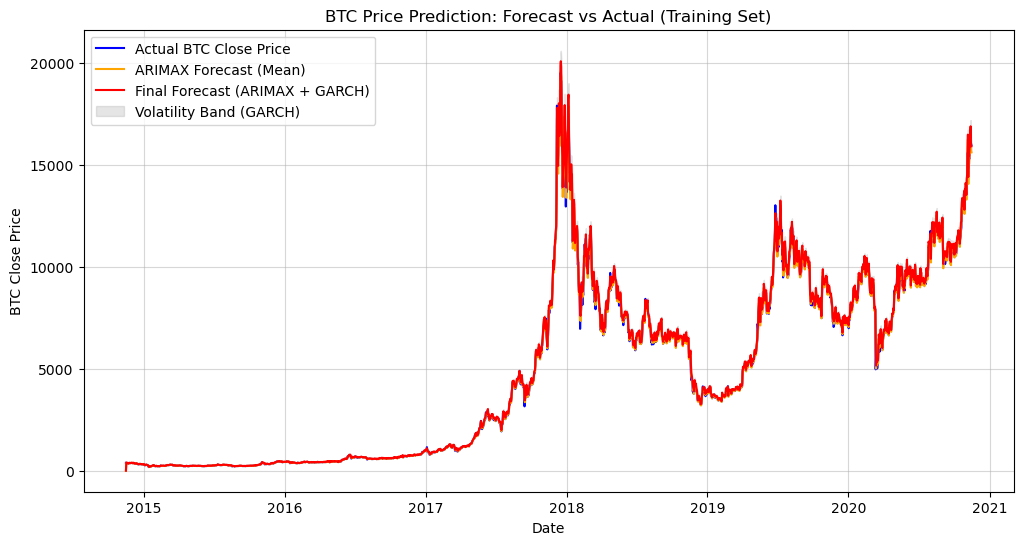

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(train_pca_df.index, train_actual_org, label='Actual BTC Close Price', color='blue')
plt.plot(train_pca_df.index, np.exp(train_arimax_pred) - 1, label='ARIMAX Forecast (Mean)', color='orange')
plt.plot(train_pca_df.index, train_arima_garch_pred_org, label='Final Forecast (ARIMAX + GARCH)', color='red')
plt.fill_between(
    train_pca_df.index,
    volatility_band_lower,
    volatility_band_upper,
    color="gray",
    alpha=0.2,
    label="Volatility Band (GARCH)"
)
plt.title("BTC Price Prediction: Forecast vs Actual (Training Set)")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### ARIMA & GARCH (out-of-sample) prediction on val_pca_df

In [46]:
# Extract exogenous & target variables for the val set
val_exog = val_pca_df[exog_vars]
val_actual = val_pca_df['btc_close']

# ARIMAX forecast for the val set
val_arimax_pred = arimax_results.forecast(steps=len(val_pca_df), exog=val_exog).values.flatten()

# GARCH conditional volatility for the val set
val_garch_volatility = garch_fit.forecast(horizon=len(val_pca_df)).variance.values[-1]

# Combine ARIMAX forecast and GARCH volatility (val set)
val_arima_garch_pred = val_arimax_pred + val_garch_volatility

In [47]:
arima_garch_rmse = root_mean_squared_error(val_actual, val_arima_garch_pred)  # RMSE
arima_garch_mae = mean_absolute_error(val_actual, val_arima_garch_pred)  # MAE
arima_garch_mape = (abs((val_actual - val_arima_garch_pred) / (val_actual + 1e-10)).mean()) * 100

# Create a new DataFrame for ARIMA metrics
arima_garch_metrics_df = pd.DataFrame({
    'Model': ['ARIMA_GARCH_VAL'],
    'RMSE': [arima_garch_rmse],
    'MAE': [arima_garch_mae],
    'MAPE': [arima_garch_mape]
})

arima_garch_metrics_df.to_csv("../results/metrics/val_arima_garch_metrics.csv", index=False)

arima_garch_metrics_df

In [48]:
# Undo log transformation val_pca_df
val_arima_garch_pred_org = np.exp(val_arima_garch_pred) - 1
val_actual_org = np.exp(val_actual) - 1
volatility_band_lower = np.exp(val_arima_garch_pred - val_garch_volatility) - 1
volatility_band_upper = np.exp(val_arima_garch_pred + val_garch_volatility) - 1

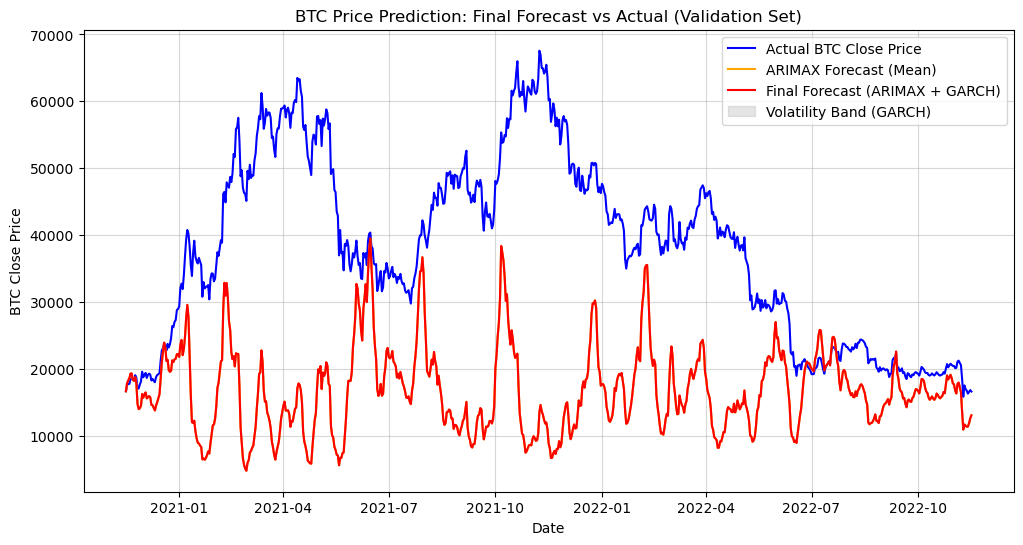

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(val_pca_df.index, val_actual_org, label='Actual BTC Close Price', color='blue')
plt.plot(val_pca_df.index, np.exp(val_arimax_pred) - 1, label='ARIMAX Forecast (Mean)', color='orange')
plt.plot(val_pca_df.index, val_arima_garch_pred_org, label='Final Forecast (ARIMAX + GARCH)', color='red')
plt.fill_between(
    val_pca_df.index,
    volatility_band_lower,
    volatility_band_upper,
    color="gray",
    alpha=0.2,
    label="Volatility Band (GARCH)"
)
plt.title("BTC Price Prediction: Final Forecast vs Actual (Validation Set)")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid(True, alpha=0.5)
plt.savefig("../results/images/val_arima_garch.png")
plt.show()
plt.close()

### Extract residuals from ARIMA-GARCH prediction and actual values from val_pca_df

In [50]:
train_residuals = val_actual - val_arima_garch_pred

train_residuals_df = pd.DataFrame({
    'Date': val_pca_df.index,
    'SARIMA-GARCH Prediction': val_arima_garch_pred,
    'Residuals': train_residuals
})

train_residuals_df.to_csv("../data/final/train_residuals_df.csv", index=False)

### ARIMA & GARCH (out-of-sample) prediction on test_pca_df

In [51]:
# Extract exogenous & target variables for the test set
test_exog = test_pca_df[exog_vars]
test_actual = test_pca_df['btc_close']

# ARIMAX forecast for the test set
test_arimax_pred = arimax_results.forecast(steps=len(test_pca_df), exog=test_exog).values.flatten()

# GARCH conditional volatility for the test set
test_garch_volatility = garch_fit.forecast(horizon=len(test_pca_df)).variance.values[-1]

# Combine ARIMAX forecast and GARCH volatility (test set)
test_arima_garch_pred = test_arimax_pred + test_garch_volatility

In [52]:
test_arima_garch_rmse = root_mean_squared_error(test_actual, test_arima_garch_pred)  # RMSE
test_arima_garch_mae = mean_absolute_error(test_actual, test_arima_garch_pred)  # MAE
test_arima_garch_mape = (abs((test_actual - test_arima_garch_pred) / (test_actual + 1e-10)).mean()) * 100

# Create a new DataFrame for ARIMA metrics
test_arima_garch_metrics_df = pd.DataFrame({
    'Model': ['ARIMA_GARCH_TEST'],
    'RMSE': [test_arima_garch_rmse],
    'MAE': [test_arima_garch_mae],
    'MAPE': [test_arima_garch_mape]
})

test_arima_garch_metrics_df.to_csv("../results/metrics/test_arima_garch_metrics.csv", index=False)

test_arima_garch_metrics_df

In [57]:
test_arima_garch_metrics_df

,Model,RMSE,MAE,MAPE
0,ARIMA_GARCH_TEST,1.033735,0.876019,8.124629


In [53]:
# Undo log transformation test_pca_df
test_arima_garch_pred_org = np.exp(test_arima_garch_pred) - 1
test_actual_org = np.exp(test_actual) - 1
volatility_band_lower = np.exp(test_arima_garch_pred - test_garch_volatility) - 1
volatility_band_upper = np.exp(test_arima_garch_pred + test_garch_volatility) - 1

### Visualization on test_pca_df

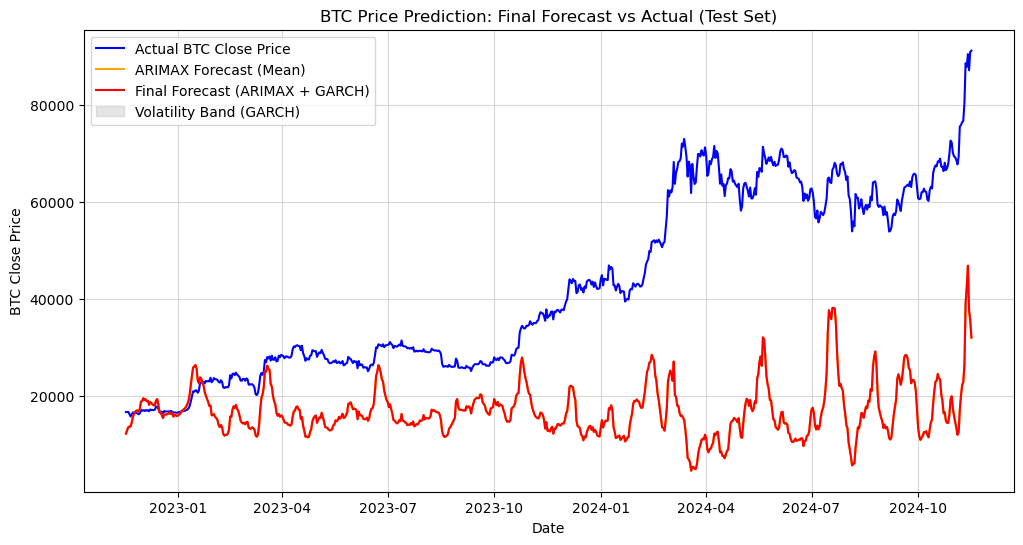

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(test_pca_df.index, test_actual_org, label='Actual BTC Close Price', color='blue')
plt.plot(test_pca_df.index, np.exp(test_arimax_pred) - 1, label='ARIMAX Forecast (Mean)', color='orange')
plt.plot(test_pca_df.index, test_arima_garch_pred_org, label='Final Forecast (ARIMAX + GARCH)', color='red')
plt.fill_between(
    test_pca_df.index,
    volatility_band_lower,
    volatility_band_upper,
    color="gray",
    alpha=0.2,
    label="Volatility Band (GARCH)"
)
plt.title("BTC Price Prediction: Final Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid(True, alpha=0.5)
plt.savefig("../results/images/test_arima_garch.png")
plt.show()
plt.close()

### Extract residuals from ARIMA-GARCH prediction and actual values from test_pca_df

In [55]:
test_residuals = test_actual - test_arima_garch_pred

test_residuals_df = pd.DataFrame({
    'Date': test_pca_df.index,
    'SARIMA-GARCH Prediction': test_arima_garch_pred,
    'Residuals': test_residuals
})

test_residuals_df.to_csv("../data/final/test_residuals_df.csv", index=False)